# Custom Dataset

This notebook shows how to create a custom dataset in PyTorch.
We give to the dataset a CSV file with the following columns:
- `index`: The unique identifier for each tweet.
- `tweet_text_clean`: The cleaned version of the tweet text. (no URLS and mentions)
- `img_text`: The text extracted from the image, if available. (otherwise NaN)
- `binary_hate`: A binary label indicating whether the tweet contains hate speech or not. (threshold at 0.5)
- `split`: The split of the dataset (train, test, or val).
And the folder containing the images (each should be named as `index.jpg`). Finally, one can add a transformation to the images.

The new object can then be used in a DataLoader to train a model.

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = 'MMHS150K/MMHS150K_text_in_image.csv'

dataset = pd.read_csv(DATASET_PATH)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, split, transform=None):
        """ __init__ function for CustomDataset

        Args:
            csv_file (str): Path to the csv file containing the dataset information
            img_dir (str): Path to the directory containing the images
            split (str): 'train' or 'test' or 'val'
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.dataset = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.split = split
        self.transform = transform
        
        # Number of images in the dataset
        self.dataset_len = len(self.dataset)
        
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_index = self.dataset['index'].values[idx]
        
        img_path = self.img_dir + str(image_index) + '.jpg'
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataset[self.dataset['index'] == image_index]['binary_hate'].values[0]
        tweet_text = self.dataset[self.dataset['index'] == image_index]['tweet_text_clean'].values[0]
        img_text = self.dataset[self.dataset['index'] == image_index]['img_text'].values[0]
        
        sample = {'image': image, 'label': label, 'tweet_text': tweet_text, 'img_text': img_text}
        
        return sample

# Example

Use the CSV created from `reformat_data.ipynb` and the images from the `MMHS150K/img_resized/` folder to create a custom dataset.
Then just use the DataLoader to plot some images, could be instead used to train a model.

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_31928/3387454787.py:26: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from current font.
  plt.tight_layout()
/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_31928/3387454787.py:26: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  plt.tight_layout()
/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_31928/3387454787.py:26: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_31928/3387454787.py:26: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/Users/marin/anaconda3/envs/dl/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/marin/anaconda3/envs/dl/lib/python3.10/site-packag

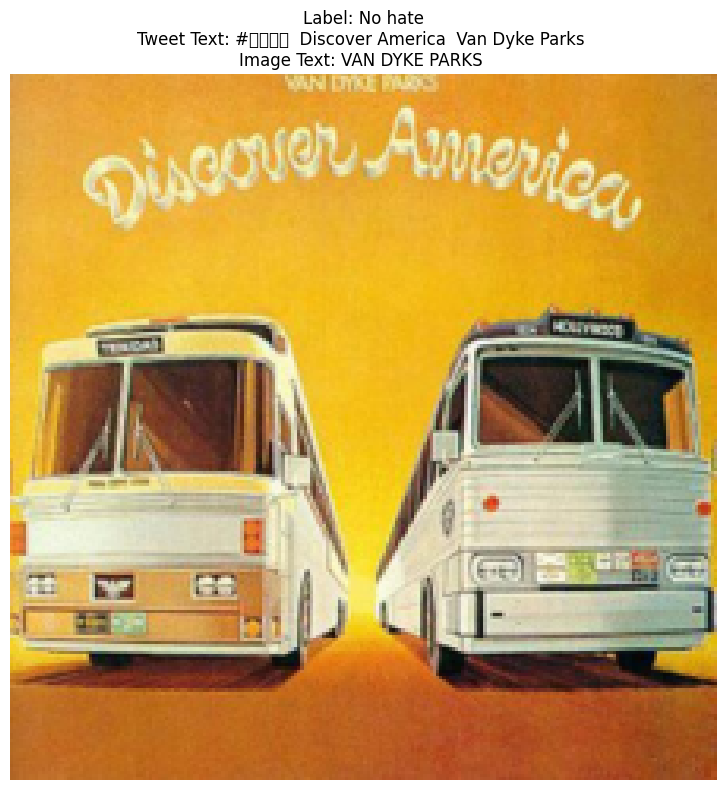

In [11]:
# Create a transform for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(20),
    transforms.ToTensor()
])

# Create a CustomDataset object
dataset = CustomDataset(csv_file=DATASET_PATH, img_dir='MMHS150K/img_resized/', split='train', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Plot the first image
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
data = next(iter(dataloader))
image = data['image']
label = data['label']
tweet_text = data['tweet_text']
img_text = data['img_text']

axs.imshow(image[0].permute(1, 2, 0))
axs.set_title(f'Label: {"Hate" if label[0] == 1 else "No hate"}\nTweet Text: {tweet_text[0]}\nImage Text: {img_text[0]}')
axs.axis('off')

plt.tight_layout()
plt.show()